In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os

In [14]:
import joblib
from skimage.io import imread
from skimage.transform import resize

In [15]:
def resize_all(src, pklname, include, width=150, height=None):
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1}) images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))[:,:,:3]
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir)
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [16]:
data_path = fr'HoldImages'
os.listdir(data_path)

['Slopers', 'Footholds', 'Jugs']

In [17]:
base_name = 'holds'
width = 80
include = {'Jugs', 'Footholds', 'Slopers'}
resize_all(src=data_path, pklname=base_name, width=width, include=include)

Slopers
Footholds
Jugs


In [18]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  148
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80) images in rgb
image shape:  (80, 80, 3)
labels: ['Footholds' 'Jugs' 'Slopers']


Counter({'Footholds': 56, 'Jugs': 50, 'Slopers': 42})

In [19]:
X = np.array(data['data'])
y = np.array(data['label'])

In [20]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog

 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        newx = np.array([skimage.color.rgb2gray(img) for img in X])
        x = np.array([img for img in newx])
        return x
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [22]:
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
img_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(2, 2), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = img_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))


Percentage correct:  60.0


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
 
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(2, 2), (3, 3), (4, 4)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(2, 2)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    }
]

In [32]:
grid_search = GridSearchCV(img_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
clf = CalibratedClassifierCV(grid_search) 
grid_res = grid_search.fit(X_train, y_train)
print(grid_res.best_score_)


Fitting 3 folds for each of 14 candidates, totalling 42 fits
0.7376068376068375


In [33]:
calibration_clf = CalibratedClassifierCV(grid_res.best_estimator_)
clf_res = calibration_clf.fit(X_train, y_train)


In [34]:
joblib.dump(clf_res, 'hog_sgd_model.pkl');

In [35]:
grid_res.best_estimator_

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(pixels_per_cell=(4, 4))),
                ('scalify', StandardScaler()),
                ('classify', SGDClassifier(random_state=42))])

In [36]:
grid_res.best_score_

0.7376068376068375

In [38]:
best_pred = clf_res.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))


Percentage correct:  63.333333333333336



 ['Footholds', 'Jugs', 'Slopers']


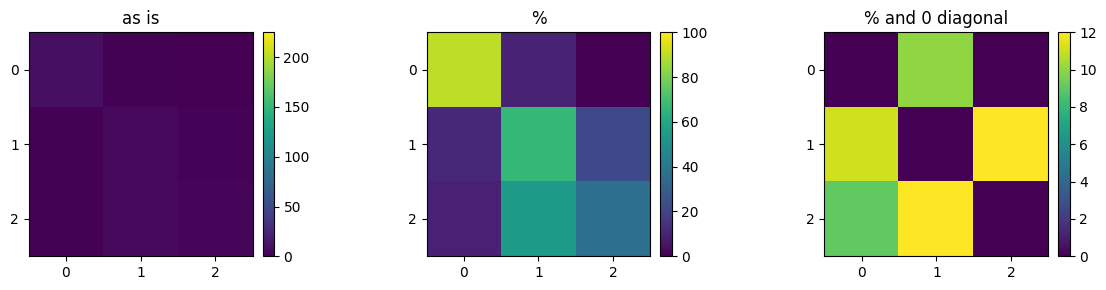

In [30]:
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
cmx_svm = confusion_matrix(y_test, best_pred)
plot_confusion_matrix(cmx_svm, vmax1=225, vmax2=100, vmax3=12)
print('\n', sorted(np.unique(y_test)))

In [39]:
im = imread("foot.png")[:,:,:3]
im = resize(im, (80, 80)) #[:,:,::-1]
clf_res.predict_proba(np.array([im]))

array([[0.79313178, 0.1156491 , 0.09121911]])

In [40]:
im = imread("newjug.png")[:,:,:3]
im = resize(im, (80, 80)) #[:,:,::-1]
clf_res.predict_proba(np.array([im]))

array([[0.30677067, 0.63940722, 0.05382211]])

In [42]:
im = imread("sloper.png")[:,:,:3]
im = resize(im, (80, 80)) #[:,:,::-1]
clf_res.predict_proba(np.array([im]))

array([[0.22293569, 0.56981604, 0.20724827]])

In [51]:
test_data = fr'Tests'
test_files = os.listdir(test_data)
for file in test_files:
    print(file)
    im = imread(f'Tests/{file}')[:,:,:3]
    im = resize(im, (80, 80)) #[:,:,::-1]
    clf_res.predict_proba(np.array([im]))